In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.models import load_model

In [2]:
X_test_eval = np.load(os.path.sep.join(['data', 'eval_sequences.npy']))
y_test_eval = np.load(os.path.sep.join(['data', 'eval_labels.npy']))

#Load the tokenizer
with open("data/tokenizer.json") as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

reverse_word_index = dict([(value, key) for key, value in tokenizer.word_index.items()])

filepath = "saved_model_cfg_8"

print("Unseen:", X_test_eval.shape, y_test_eval.shape)

Unseen: (11775, 16) (11775,)


In [4]:
model = load_model(filepath)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 16, 8)             20000     
                                                                 
 gru_14 (GRU)                (None, 16, 64)            14208     
                                                                 
 dropout_14 (Dropout)        (None, 16, 64)            0         
                                                                 
 batch_normalization_14 (Bat  (None, 16, 64)           256       
 chNormalization)                                                
                                                                 
 gru_15 (GRU)                (None, 128)               74496     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                      

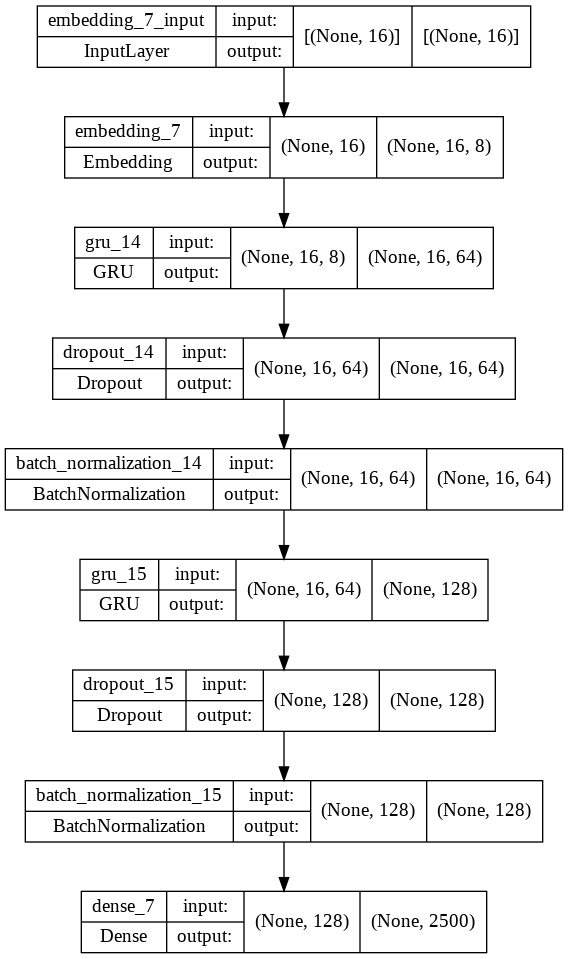

In [6]:
model.summary()
tf.keras.utils.plot_model(model, to_file="images/model_architecture.png", show_shapes=True, show_layer_names=True)

## Model performance

In [7]:
_, accuracy = model.evaluate(X_test_eval, y_test_eval)
print('Evaluation accuracy: %.2f' % (accuracy*100))

368/368 [==============================] - 5s 4ms/step - loss: 3.7965 - accuracy: 0.3056
Evaluation accuracy: 30.56


In [8]:
#Get predictions from evaluation data
predictions = model.predict(X_test_eval)

accuracy_array = np.array([])

#Add the individual prediction accuracies to a numpy array
for i in range(0, predictions.shape[0]):
  accuracy_array = np.append(accuracy_array, predictions[i][y_test_eval[i]])

In [9]:
#Find 10 predictions with the highest and lowest accuracies
max_10_index = accuracy_array.argsort()[-10:][::-1]
min_10_index = accuracy_array.argsort()[:10]

max_10_sequences = X_test_eval[max_10_index]
max_10_labels = y_test_eval[max_10_index]
min_10_sequences = X_test_eval[min_10_index]
min_10_labels = y_test_eval[min_10_index]

In [10]:
#Print the highest accuracy predictions
print("Highest accuracy predictions:\n")
print("Index. Sequence -> Label. Accuracy")

for i in range(0, 10):
  print(f"{i}. {' '.join([reverse_word_index[num] for num in max_10_sequences[i]])} ->  {reverse_word_index[max_10_labels[i]]}. {accuracy_array[max_10_index[i]]}")

Highest accuracy predictions:

Index. Sequence -> Label. Accuracy
0. streets <br> deep inside my love is burn for you <br> night in tokyo <br> full ->  of. 0.9954119324684143
1. in tokyo <br> full of fantasy <br> round around we move together <br> tokyo <br> full ->  of. 0.9886612892150879
2. take you to the party this time <br> gonna feel the sun dancing your melody harmony ->  <br>. 0.9870499968528748
3. the <br> space racing <br> running into the light <br> i can feel <br> a kind ->  of. 0.9867167472839355
4. ever <br> we can drive we take the time <br> over the city lights <br> full ->  of. 0.9849352836608887
5. love emotion <br> baby take me now to your life in extasy <br> wonderful <br> full ->  of. 0.9841687083244324
6. time for the rest of our life an <br> gimme your heart for a beautiful night ->  <br>. 0.9838120341300964
7. hold me by your side <br> can you save my heart <br> love is in the ->  air. 0.9828096628189087
8. love <br> do you fool me with emotion <br> all your lov

In [11]:
#Print the lowest accuracy predictions
print("Lowest accuracy predictions:\n")
print("Index. Sequence -> Label. Accuracy")

for i in range(0, 10):
  print(f"{i}. {' '.join([reverse_word_index[num] for num in min_10_sequences[i]])} ->  {reverse_word_index[min_10_labels[i]]}. {accuracy_array[min_10_index[i]]}")

Lowest accuracy predictions:

Index. Sequence -> Label. Accuracy
0. rainy day for me <br> its a rainy day you see <br> maybe i should have ->  saved. 3.5145703621702884e-12
1. know my love is like thunder <br> pretty lady come to me <br> uoo o o ->  o. 1.0138079611921036e-11
2. know this love is like hunger <br> pretty baby set me free <br> uoo o o ->  o. 1.1127250162945579e-11
3. you know my love is like thunder <br> pretty lady come to me <br> uoo o ->  o. 6.926634266157805e-11
4. your heartbeat goes away <br> it will come back <br> dont be shy when you <OOV> ->  begins. 9.480184692822746e-11
5. love <br> change you feelings <br> upside down <br> im <OOV> all around <br> boy you ->  sent. 1.0427343016816693e-10
6. you know this love is like hunger <br> pretty baby set me free <br> uoo o ->  o. 1.1123266890900041e-10
7. <br> you know my love is like thunder <br> pretty lady come to me <br> uoo ->  o. 1.2150976058666885e-10
8. believe in me <br> on my own <br> when you were just a stra

## Lisätapoja

#### Ylläolevat käsittelevät vain vastausta kohti annettuja todennäköisyyksiä, eli aina acc per correct label on tallennettu. Olisi esim. yllä mielenkiinoista tietää, että jos oikeaa labelia kohti on melkein 0 todennäköisyys, niin mitä mille sanalle malli on antanut suurimman todennäköisyyden

In [12]:
predictions = model.predict(X_test_eval)
predicted_labels = np.argmax(predictions, axis=1)

In [13]:
predicted_labels == y_test_eval

array([ True, False,  True, ..., False,  True, False])

In [14]:
correct_idx_acc = [(i, predictions[i].max(), predicted_labels[i]) for i, value in enumerate(predicted_labels == y_test_eval) if value == True]
correct_idx_acc_max = sorted(correct_idx_acc, key = lambda tup: tup[1], reverse=True)

In [15]:
correct_idx_acc_max[:10]

[(300, 0.99541193, 16),
 (312, 0.9886613, 16),
 (9707, 0.98705, 2),
 (8476, 0.98671675, 16),
 (259, 0.9849353, 16),
 (9538, 0.9841687, 16),
 (4152, 0.98381203, 2),
 (7542, 0.98280966, 514),
 (2084, 0.98192835, 16),
 (9088, 0.98125446, 2)]

In [16]:
#Print the highest accuracy predictions (correct)
print("Highest accuracy, correct predictions:\n")
print("Index. Sequence -> Label. Accuracy")

for i, acc, label in correct_idx_acc_max[:10]:
    print(f"{i}. {' '.join([reverse_word_index[num] for num in X_test_eval[i]])} ->  {reverse_word_index[y_test_eval[i]]}. {acc}")

Highest accuracy, correct predictions:

Index. Sequence -> Label. Accuracy
300. streets <br> deep inside my love is burn for you <br> night in tokyo <br> full ->  of. 0.9954119324684143
312. in tokyo <br> full of fantasy <br> round around we move together <br> tokyo <br> full ->  of. 0.9886612892150879
9707. take you to the party this time <br> gonna feel the sun dancing your melody harmony ->  <br>. 0.9870499968528748
8476. the <br> space racing <br> running into the light <br> i can feel <br> a kind ->  of. 0.9867167472839355
259. ever <br> we can drive we take the time <br> over the city lights <br> full ->  of. 0.9849352836608887
9538. love emotion <br> baby take me now to your life in extasy <br> wonderful <br> full ->  of. 0.9841687083244324
4152. time for the rest of our life an <br> gimme your heart for a beautiful night ->  <br>. 0.9838120341300964
7542. hold me by your side <br> can you save my heart <br> love is in the ->  air. 0.9828096628189087
2084. love <br> do you fool 

In [17]:
wrong_idx_acc = [(i, predictions[i].max(), predicted_labels[i]) for i, value in enumerate(predicted_labels == y_test_eval) if value == False]
wrong_idx_acc_max = sorted(wrong_idx_acc, key = lambda tup: tup[1], reverse=True)

In [18]:
wrong_idx_acc_max[:10]

[(11122, 0.97805667, 16),
 (8809, 0.9738003, 2),
 (8230, 0.96795547, 16),
 (895, 0.9579035, 2),
 (1620, 0.95720613, 2),
 (8130, 0.9521318, 2),
 (4143, 0.95177585, 2),
 (5160, 0.9515838, 2),
 (5267, 0.9515838, 2),
 (2726, 0.951135, 2)]

In [39]:
#Print the highest accuracy predictions (wrong)
print("Highest accuracy, wrong predictions:\n")
print("Index. Sequence -> Label. Accuracy")

for i, acc, label in wrong_idx_acc_max[:50]:
    print(f"{i}. {' '.join([reverse_word_index[num] for num in X_test_eval[i]])} ->  {reverse_word_index[label]}. {acc}.\nCorrect label was: {reverse_word_index[y_test_eval[i]]} ({y_test_eval[i]})\n")

Highest accuracy, wrong predictions:

Index. Sequence -> Label. Accuracy
11122. <br> you are a wonder <br> youre my golden boy <br> you are the loving kind ->  of. 0.9780566692352295.
Correct label was: <br> (2)

8809. mine <br> step by step i go so crazy <br> i dont king of your delight ->  <br>. 0.9738003015518188.
Correct label was: my (7)

8230. in my head <br> ive tried to be <OOV> with you <br> but in the end ->  of. 0.967955470085144.
Correct label was: youll (120)

895. fall down my love <br> ill be your love <br> all this night and then forever ->  <br>. 0.9579035043716431.
Correct label was: you (3)

1620. your hot desire <br> got my mind on fire <br> with the flame of your fantasy ->  <br>. 0.957206130027771.
Correct label was: really (142)

8130. hand <br> and come to me to me <br> come to me baby in my fantasy ->  <br>. 0.9521318078041077.
Correct label was: world (110)

4143. you <br> baby light me up <br> gimme your time for the rest of our life ->  <br>. 0.9517758488655

In [22]:
from collections import Counter
#Print the most common labels in the dataset
[(label, reverse_word_index[label], count) for label, count in Counter(y_test_eval).most_common()[:20]]

[(2, '<br>', 1747),
 (3, 'you', 570),
 (5, 'i', 388),
 (6, 'me', 346),
 (4, 'the', 315),
 (7, 'my', 277),
 (8, 'to', 252),
 (10, 'your', 215),
 (12, 'love', 215),
 (9, 'and', 181),
 (11, 'a', 139),
 (14, 'is', 121),
 (18, 'be', 117),
 (17, 'baby', 107),
 (13, 'in', 102),
 (15, 'for', 101),
 (24, 'can', 98),
 (21, 'dont', 96),
 (19, 'on', 93),
 (16, 'of', 91)]

In [23]:
#Print the most common predictions
[(label, reverse_word_index[label], count) for label, count in Counter(predicted_labels).most_common()[:20]]

[(2, '<br>', 3008),
 (5, 'i', 1761),
 (3, 'you', 804),
 (4, 'the', 595),
 (6, 'me', 530),
 (18, 'be', 331),
 (12, 'love', 301),
 (8, 'to', 278),
 (7, 'my', 192),
 (24, 'can', 190),
 (29, 'wanna', 182),
 (11, 'a', 167),
 (14, 'is', 142),
 (25, 'feel', 122),
 (10, 'your', 119),
 (26, 'night', 107),
 (36, 'heart', 103),
 (16, 'of', 101),
 (41, 'know', 88),
 (15, 'for', 85)]

In [37]:
#Print the most overfitting labels (How many more were found in the predicted than the real dataset)
[(label, reverse_word_index[label], count) for label, count in (Counter(predicted_labels) - Counter(y_test_eval)).most_common()[:10]]

[(5, 'i', 1373),
 (2, '<br>', 1261),
 (4, 'the', 280),
 (3, 'you', 234),
 (18, 'be', 214),
 (6, 'me', 184),
 (29, 'wanna', 112),
 (24, 'can', 92),
 (12, 'love', 86),
 (36, 'heart', 55)]

In [38]:
#Print the most underfitting labels (How many more were found in the real dataset than the predicted dataset)
[(label, reverse_word_index[label], count) for label, count in (Counter(y_test_eval) - Counter(predicted_labels)).most_common()[:10]]

[(9, 'and', 107),
 (10, 'your', 96),
 (7, 'my', 85),
 (1, '<OOV>', 79),
 (23, 'all', 73),
 (32, 'just', 60),
 (20, 'im', 60),
 (17, 'baby', 58),
 (27, 'now', 52),
 (34, 'take', 48)]

In [93]:
#Average length of sentence before false prediction (Length after last <br>).
a = [item[np.where(item == 2)[0][-1]:].size for item in X_test_eval[[i for i, _, _ in wrong_idx_acc_max[:50]]]]
print(f"Average length of a sentence before false prediction: {sum(a) / len(a)}")

Average length of a sentence before false prediction: 6.86
